The idea of this test is to check if the noise model matrix B of 4S changes if the planet is in the data. Can we compute it once for contrast curves and MCMC?

In [1]:
import sys
from copy import deepcopy
from pathlib import Path
import numpy as np
import json
from applefy.detections.contrast import Contrast
import matplotlib.pyplot as plt

from fours.utils.data_handling import load_adi_data
from fours.detection_limits.applefy_wrapper import FourSDataReduction

from applefy.utils.file_handling import open_fits
from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

# Load the data

In [2]:
dataset_file = Path("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/09_new_rotation_loss/x2_different_residual_creations/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [3]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [4]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
fake_planet_config["flux_ratio"] = mag2flux_ratio(9.5)

In [6]:
data_with_fake_planet = add_fake_planets(
    input_stack=deepcopy(science_data),
    psf_template=psf_template,
    parang=angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

## Train 4S on the data without the fake planet

In [43]:
import torch
from fours.models.psf_subtraction import FourS

In [44]:
experiment_root_dir = Path("/fast/mbonse/s4/70_results/test_fast_science/")
experiment_root_dir.mkdir(exist_ok=True)

In [46]:
fours_model = FourS(
    science_cube=science_data,
    adi_angles=angles,
    psf_template=psf_template,
    device="cpu",
    work_dir=experiment_root_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=10000,
    psf_fwhm=3.6,
    right_reason_mask_factor=1.5)

In [ ]:
fours_model.fit_noise_model(
        num_epochs=500,
        training_name="Data_no_fake_planet",
        logging_interval=10)

S4 model: Fit noise model ... 

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
fours_model.save_models(
    file_name_noise_model="noise_model_no_planet.pkl",
    file_name_normalization_model="normalization_model_no_planet.pkl")

# Train the model a second time on the data with fake planet

In [ ]:
fours_model_with_planet = FourS(
    science_cube=data_with_fake_planet,
    adi_angles=angles,
    psf_template=psf_template,
    device=0,
    work_dir=experiment_root_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=10000,
    psf_fwhm=3.6,
    right_reason_mask_factor=1.5)

In [ ]:
fours_model_with_planet.fit_noise_model(
        num_epochs=500,
        training_name="Data_with_fake_planet",
        logging_interval=10)

In [ ]:
fours_model_with_planet.save_models(
    file_name_noise_model="noise_model_with_planet.pkl",
    file_name_normalization_model="normalization_model_with_planet.pkl")

## Compute the residuals

In [ ]:
mean_residual_no_planet, median_residual_no_planet = fours_model.compute_residuals()

In [ ]:
mean_residual_with_planet, median_residual_with_planet = fours_model_with_planet.compute_residuals()

# Create some plots

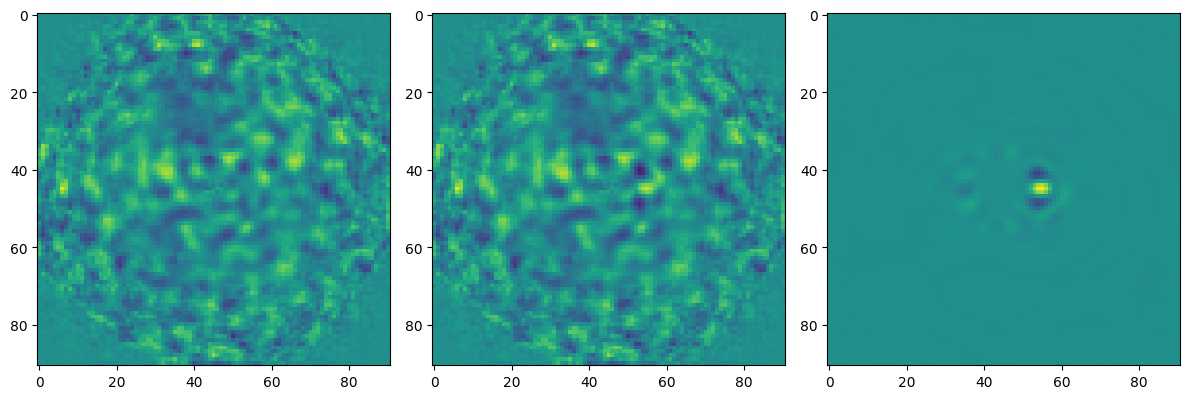

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.imshow(mean_residual_no_planet, vmin=-0.05, vmax=0.05)
ax2.imshow(mean_residual_with_planet, vmin=-0.05, vmax=0.05)
ax3.imshow(mean_residual_with_planet - mean_residual_no_planet, vmin=-0.04, vmax=0.04)

plt.tight_layout()

Create a new model but re-load the pre-trained model matrix

In [23]:
fours_model_reloaded = FourS(
    science_cube=data_with_fake_planet,
    adi_angles=angles,
    psf_template=psf_template,
    device=0,
    work_dir=experiment_root_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=10000,
    psf_fwhm=3.6,
    right_reason_mask_factor=1.5)

In [24]:
pre_trained_model = torch.load(experiment_root_dir / "models/noise_model_no_planet.pkl")

with torch.no_grad():
    fours_model_reloaded.noise_model.betas_raw.data = pre_trained_model["betas_raw"]
    
# compute the residuals
mean_residual_with_planet_res, median_residual_with_planet_res = fours_model_reloaded.compute_residuals()

S4 model: computing residual ... [DONE]


In [26]:
np.max(mean_residual_with_planet_res - mean_residual_no_planet)

0.06486339

In [27]:
np.max(mean_residual_with_planet - mean_residual_no_planet)

0.041003

# fine tune the model

In [28]:
fours_model_reloaded.fit_noise_model(
        num_epochs=500,
        training_name="Data_with_fake_planet_fine_tuned",
        logging_interval=10)

S4 model: Fit noise model ... 

  0%|          | 0/500 [00:00<?, ?it/s]

[DONE]


In [29]:
mean_residual_with_planet_res, median_residual_with_planet_res = fours_model_reloaded.compute_residuals()

S4 model: computing residual ... [DONE]


In [30]:
np.max(mean_residual_with_planet_res - mean_residual_no_planet)

0.041227825

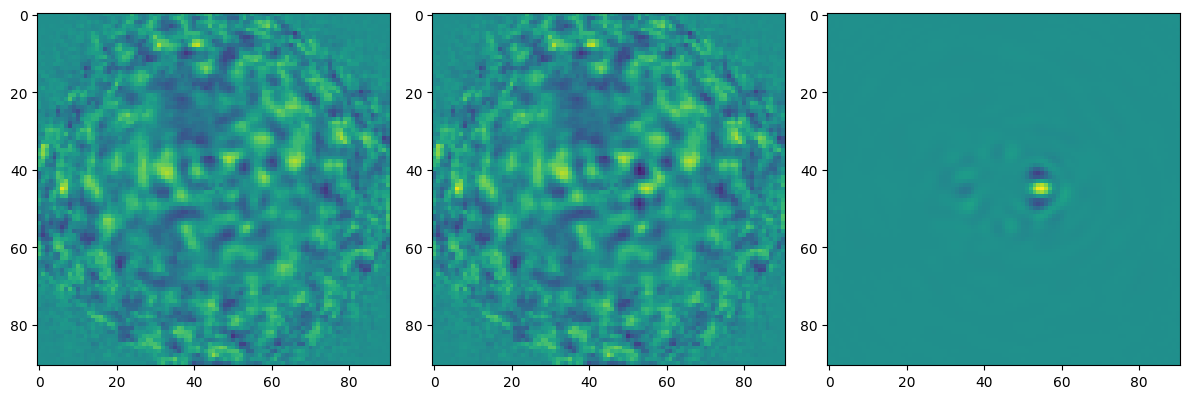

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.imshow(mean_residual_no_planet, vmin=-0.05, vmax=0.05)
ax2.imshow(mean_residual_with_planet_res, vmin=-0.05, vmax=0.05)
ax3.imshow(mean_residual_with_planet_res - mean_residual_no_planet, vmin=-0.04, vmax=0.04)

plt.tight_layout()

# how much fine-tuning is needed?

In [41]:
fours_model_reloaded = FourS(
    science_cube=data_with_fake_planet,
    adi_angles=angles,
    psf_template=psf_template,
    device=0,
    work_dir=experiment_root_dir,
    verbose=True,
    rotation_grid_subsample=1,
    noise_model_lambda=10000,
    psf_fwhm=3.6,
    right_reason_mask_factor=1.5)

pre_trained_model = torch.load(experiment_root_dir / "models/noise_model_no_planet.pkl")

with torch.no_grad():
    fours_model_reloaded.noise_model.betas_raw.data = pre_trained_model["betas_raw"]

In [42]:
mean_residual_with_planet_res, median_residual_with_planet_res = fours_model_reloaded.compute_residuals()
print(np.max(mean_residual_with_planet_res - mean_residual_no_planet))

for i in range(5):
    fours_model_reloaded.fit_noise_model(
        num_epochs=200,
        training_name="Data_with_fake_planet_fine_tuned",
        logging_interval=10)
    
    mean_residual_with_planet_res, median_residual_with_planet_res = fours_model_reloaded.compute_residuals()
    print(np.max(mean_residual_with_planet_res - mean_residual_no_planet))

S4 model: computing residual ... [DONE]
0.06486339
S4 model: Fit noise model ... 

  0%|          | 0/200 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]
0.042157866
S4 model: Fit noise model ... 

  0%|          | 0/200 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]
0.042081915
S4 model: Fit noise model ... 

  0%|          | 0/200 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]
0.041351363
S4 model: Fit noise model ... 

  0%|          | 0/200 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]
0.041349556
S4 model: Fit noise model ... 

  0%|          | 0/200 [00:00<?, ?it/s]

[DONE]
S4 model: computing residual ... [DONE]
0.041155983
